In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import concurrent.futures
import timeit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.opflow import PrimitiveOp
from qiskit.algorithms.optimizers.optimizer import POINT
from typing import Callable, List, Optional, Tuple
from qiskit.algorithms.optimizers import (
    ADAM,
    AQGD,
    CG,
    COBYLA,
    L_BFGS_B,
    GSLS,
    GradientDescent,
    NELDER_MEAD,
    NFT,
    P_BFGS,
    POWELL,
    SLSQP,
    SPSA,
    QNSPSA,
    TNC,
    SciPyOptimizer
)
from qiskit.algorithms import VQE, NumPyMinimumEigensolver, QAOA
from qiskit.utils import QuantumInstance, algorithm_globals
# from qiskit_optimization.algorithms import (
#     MinimumEigenOptimizer,
#     RecursiveMinimumEigenOptimizer,
#     SolutionSample,
#     OptimizationResultStatus,
#     WarmStartQAOAOptimizer
# )
from qiskit import Aer
import qiskit
from qiskit.providers.aer import AerSimulator
from functools import partial
from pathlib import Path
import copy
from itertools import groupby
import timeit
import sys, os
from scipy.optimize import minimize
from scipy.spatial.distance import (
    cosine
)
from qiskit.quantum_info import Statevector
# from QAOAKit import vis

sys.path.append('..')
from QAOAKit.noisy_params_optim import (
    get_pauli_error_noise_model,
    optimize_under_noise,
    get_depolarizing_error_noise_model,
    compute_expectation
)

from QAOAKit.vis import(
    vis_landscape,
    vis_landscape_heatmap,
    vis_landscape_heatmap_multi_p,
    vis_landscape_multi_p,
    vis_landscape_multi_p_and_and_count_optima,
    vis_landscape_multi_p_and_and_count_optima_MP,
    vis_multi_landscape_and_count_optima_and_mitiq_MP,
    vis_multi_landscapes_and_count_optima_and_mitiq_MP_and_one_variable,
    vis_two_BPs_p1_recon
)

from QAOAKit import (
    opt_angles_for_graph,
    get_fixed_angles,
    get_graph_id,
    get_graph_from_id,
    angles_to_qaoa_format,
    beta_to_qaoa_format,
    gamma_to_qaoa_format,
    angles_to_qiskit_format,
    angles_to_qtensor_format,
    get_3_reg_dataset_table,
    get_3_reg_dataset_table_row,
    get_full_qaoa_dataset_table_row,
    get_full_qaoa_dataset_table,
    get_fixed_angle_dataset_table,
    get_fixed_angle_dataset_table_row,
    qaoa_maxcut_energy,
    noisy_qaoa_maxcut_energy,
    angles_from_qiskit_format,

)
from QAOAKit.utils import (
    angles_from_qaoa_format,
    beta_shift_sector,
    gamma_shift_sector,
    get_curr_formatted_timestamp,
    load_partial_qaoa_dataset_table,
    obj_from_statevector,
    precompute_energies,
    maxcut_obj,
    isomorphic,
    load_weights_into_dataframe,
    load_weighted_results_into_dataframe,
    get_adjacency_matrix,
    brute_force,
    get_pynauty_certificate,
    get_full_weighted_qaoa_dataset_table,
    save_partial_qaoa_dataset_table,
    shift_parameters
)

from QAOAKit.classical import thompson_parekh_marwaha
from QAOAKit.qaoa import get_maxcut_qaoa_circuit
from QAOAKit.qiskit_interface import (
    get_maxcut_qaoa_qiskit_circuit,
    goemans_williamson,
    get_maxcut_qaoa_qiskit_circuit_unbinded_parameters
)
from QAOAKit.examples_utils import get_20_node_erdos_renyi_graphs
from QAOAKit.parameter_optimization import get_median_pre_trained_kde
from QAOAKit.compressed_sensing import (
    CS_and_one_landscape_and_cnt_optima_and_mitiq_and_one_variable,
    multi_landscapes_and_cnt_optima_and_mitiq_and_MP_and_one_variable_and_CS,
    one_D_CS_p1_generate_landscape,
    gen_p1_landscape,
    one_D_CS_p1_recon_with_given_landscapes_and_varing_sampling_frac,
    two_D_CS_p1_recon_with_given_landscapes,
    _vis_one_D_p1_recon,
    p1_generate_grad,
    _executor_of_qaoa_maxcut_energy
)
from QAOAKit.optimizer_wrapper import (
    wrap_qiskit_optimizer_to_landscape_optimizer,
    get_numerical_derivative
)

from QAOAKit.interpolate import (
    approximate_fun_value_by_2D_interpolation
)

# from qiskit_optimization import QuadraticProgram
from qiskit.algorithms.minimum_eigen_solvers.qaoa import QAOAAnsatz

# test_utils_folder = Path(__file__).parent




In [38]:

def _vis_landscapes(
        landscapes, # list of np.ndarray
        labels, # list of labels of correlated landscapes
        full_range, # dict, 
        true_optima,
        title,
        save_path, # figure save path
        params_paths, # list of list of parameters correlated to landscapes
        recon_params_path_dict=None,
        origin_params_path_dict=None
    ):

    assert len(landscapes) == len(labels)
    assert len(landscapes) == len(params_paths)

    # plt.figure
    plt.rc('font', size=28)
    if len(landscapes) == 2:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(30, 22))
    elif len(landscapes) == 3:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
    elif len(landscapes) == 4:
        fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(30, 30))
    else:
        assert False

    fig.suptitle(title)
    axs = axs.reshape(-1)

    # TODO Check ij and xy
    X, Y = np.meshgrid(full_range['beta'], full_range['gamma'])

    # c = ax.pcolormesh(X, Y, Z, cmap='viridis', vmin=Z.min(), vmax=Z.max())
    for idx, landscape in enumerate(landscapes):
        im = axs[idx].pcolormesh(X, Y, landscape) #, cmap='viridis', vmin=origin.min(), vmax=origin.max())
        axs[idx].set_title(labels[idx])
        axs[idx].set_xlabel('beta')
        axs[idx].set_ylabel('gamma')
        if isinstance(true_optima, list) or isinstance(true_optima, np.ndarray):
            axs[idx].plot(true_optima[1], true_optima[0], marker="o", color='red', markersize=7, label="true optima")

        params = params_paths[idx]
        if isinstance(params, list) or isinstance(params, np.ndarray):
            xs = [] # beta
            ys = [] # gamma
            for param in params:
                xs.append(param[1])
                ys.append(param[0])

            axs[idx].plot(xs, ys, marker="o", color='purple', markersize=5, label="optimization path")
            axs[idx].plot(xs[0], ys[0], marker="o", color='white', markersize=9, label="initial point")
            axs[idx].plot(xs[-1], ys[-1], marker="s", color='white', markersize=12, label="last point")


    fig.colorbar(im, ax=[axs[i] for i in range(len(landscapes))])
    plt.legend()
    fig.savefig(save_path, bbox_inches='tight')
    plt.show()
    plt.close('all')

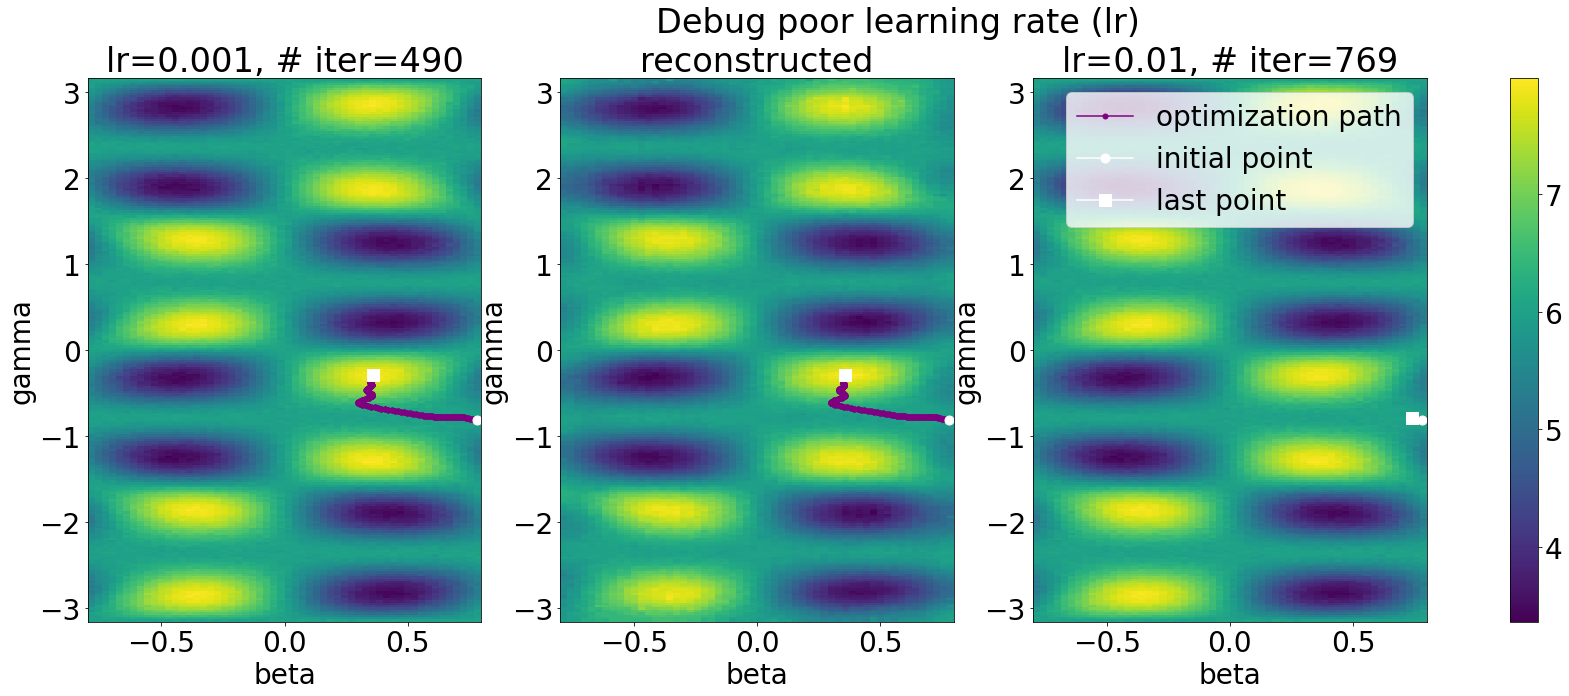

In [39]:
def vis_case1():

    # derive origin full landscapes
    data_dir = "figs/cnt_opt_miti/2022-08-10_10:14:03/G40_nQ8_p1"
    data = np.load(f"{data_dir}/data.npz", allow_pickle=True)
    origin = data['origin'].tolist()
    full_range = data['full_range'].tolist()

    # derive reconstructed landscape
    recon_path = f"{data_dir}/2D_CS_recon.npz"
    recon = np.load(recon_path, allow_pickle=True)['recon'].tolist()

    # derive optimization paths
    opt_data1 = np.load(
        "figs/cnt_opt_miti/2022-08-10_10:14:03/G40_nQ8_p1/use_cases/2022-10-08_14:32:14/use_case_data.npz",
        allow_pickle=True)

    opt_data2 = np.load(
        "figs/cnt_opt_miti/2022-08-10_10:14:03/G40_nQ8_p1/use_cases/2022-10-08_14:31:06/use_case_data.npz",
        allow_pickle=True
    )

    params_paths = [opt_data2['params_path'].tolist(), opt_data2['params_path'].tolist(), opt_data1['params_path']]

    _vis_landscapes(
        landscapes=[origin['unmitis'], recon['unmitis'], origin['unmitis']],
        labels=["lr=0.001, # iter=490", "reconstructed", "lr=0.01, # iter=769"],
        full_range=full_range,
        true_optima=None,
        title="Debug poor learning rate (lr)",
        save_path="paper_figs/case1.png",
        params_paths=params_paths
    )
vis_case1()

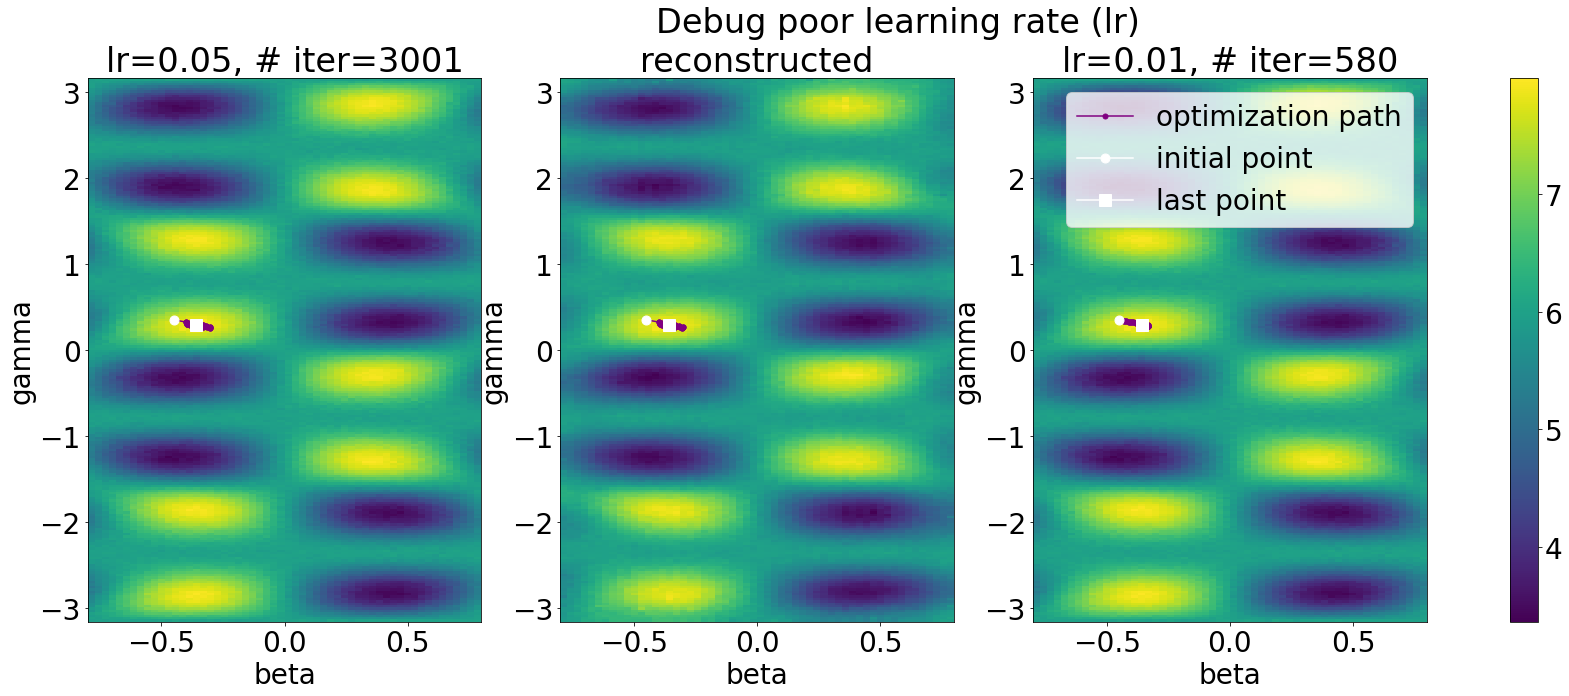

In [40]:
def vis_case2():

    # derive origin full landscapes
    data_dir = "figs/cnt_opt_miti/2022-08-10_10:14:03/G40_nQ8_p1"
    data = np.load(f"{data_dir}/data.npz", allow_pickle=True)
    origin = data['origin'].tolist()
    full_range = data['full_range'].tolist()

    # derive reconstructed landscape
    recon_path = f"{data_dir}/2D_CS_recon.npz"
    recon = np.load(recon_path, allow_pickle=True)['recon'].tolist()

    # derive optimization paths
    opt_data1 = np.load(
        "figs/cnt_opt_miti/2022-08-10_10:14:03/G40_nQ8_p1/use_cases/2022-10-08_00:15:41/use_case_data.npz",
        allow_pickle=True)

    opt_data2 = np.load(
        "figs/cnt_opt_miti/2022-08-10_10:14:03/G40_nQ8_p1/use_cases/2022-10-08_00:11:49/use_case_data.npz",
        allow_pickle=True
    )

    params_paths = [opt_data2['params_path'].tolist(), opt_data2['params_path'].tolist(), opt_data1['params_path']]

    _vis_landscapes(
        landscapes=[origin['unmitis'], recon['unmitis'], origin['unmitis']],
        labels=["lr=0.05, # iter=3001", "reconstructed", "lr=0.01, # iter=580"],
        full_range=full_range,
        true_optima=None,
        title="Debug poor learning rate (lr)",
        save_path="paper_figs/case2.png",
        params_paths=params_paths
    )
vis_case2()